In [1]:
from desc_dc2_dm_data import REPOS
from lsst.daf.persistence import Butler

import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
import numpy as np
import fitsio

from ssi_tools.layout_utils import make_hexgrid_for_tract

import lsst.geom as geom

## First Let's Get the Butler and a Tract

In [4]:
butler = Butler(REPOS['2.2i_dr6_wfd'])
skymap = butler.get("deepCoadd_skyMap")

In [5]:
# this list is hard coded - the gen 2 butler doesn't have a method for introspection
meta = {}
meta["all_tracts"] = """2723  2730  2897  2904  3076  3083  3259  3266  3445  3452  3635  3642  3830  3837  4028  4035  4230  4428  4435  4636  4643  4851  4858  5069
2724  2731  2898  2905  3077  3084  3260  3267  3446  3453  3636  3643  3831  4022  4029  4224  4231  4429  4436  4637  4644  4852  4859  5070
2725  2732  2899  2906  3078  3085  3261  3268  3447  3454  3637  3825  3832  4023  4030  4225  4232  4430  4437  4638  4645  4853  4860  5071
2726  2733  2900  2907  3079  3086  3262  3441  3448  3631  3638  3826  3833  4024  4031  4226  4233  4431  4438  4639  4646  4854  5065  5072
2727  2734  2901  2908  3080  3256  3263  3442  3449  3632  3639  3827  3834  4025  4032  4227  4234  4432  4439  4640  4647  4855  5066  5073
2728  2735  2902  3074  3081  3257  3264  3443  3450  3633  3640  3828  3835  4026  4033  4228  4235  4433  4440  4641  4648  4856  5067  5074
2729  2896  2903  3075  3082  3258  3265  3444  3451  3634  3641  3829  3836  4027  4034  4229  4236  4434  4441  4642  4850  4857  5068""".split()

In [31]:
ti = skymap[4030]

## Make a Grid of objects

We will use the `fsi_tools` package to make a hexagonal grid of object positions.

In [32]:
grid = make_hexgrid_for_tract(ti, rng=10)

(0.0, 640.0)

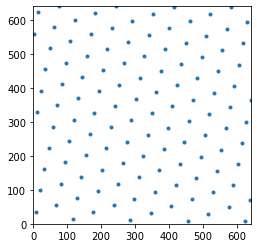

In [33]:
plt.figure()
plt.plot(grid["x"], grid["y"], '.')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(0, 640)
plt.ylim(0, 640)

Neat!

## Building the Source Catalog

In [34]:
srcs = fitsio.read(
    "/global/cfs/cdirs/lsst/groups/fake-source-injection/DC2/catalogs/"
    "cosmoDC2_v1.1.4_small_fsi_catalog.fits",
)

In [39]:
rng = np.random.RandomState(seed=10)
inds = rng.choice(len(srcs), size=len(grid), replace=True)

tract_sources = srcs[inds].copy()
tract_sources["raJ2000"] = np.deg2rad(grid["ra"])
tract_sources["decJ2000"] = np.deg2rad(grid["dec"])

## Now Cut to Just the First Patch

In [40]:
patch = ti[0]

# TODO: we may want to expand this box to account for nbrs light
msk = patch.getOuterBBox().contains(grid["x"], grid["y"])

print("found %d objects in patch %s" % (np.sum(msk), "%d,%d" % patch.getIndex()))

found 4741 objects in patch 0,0


## Run the Stack FSI Code

In [43]:
fitsio.write("ssi.fits", tract_sources[msk][0:100], clobber=True)

In [44]:
!insertFakes.py \
    /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1 \
    --output test/ \
    --id tract=4030 patch=0,0 \
    filter=r -c fakeType=ssi.fits \
    --clobber-config --no-versions

CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/registry.

## Make an Image

{'tract': 4030, 'patch': '0,0', 'filter': 'r'}


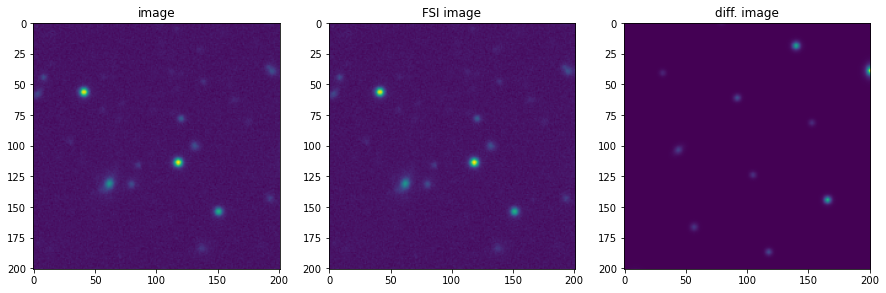

In [52]:
butler = Butler("./test/")

cutoutSize = geom.ExtentI(201, 201)
ra = np.mean(tract_sources[msk][0:100]["raJ2000"]) / np.pi * 180.0
dec = np.mean(tract_sources[msk][0:100]["decJ2000"]) / np.pi * 180.0
point = geom.SpherePoint(ra, dec, geom.degrees)

skymap = butler.get("deepCoadd_skyMap")
tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))
bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
coaddId = {
    'tract': tractInfo.getId(), 
    'patch':  "%d,%d" % patchInfo.getIndex(),
    'filter': 'r'
}
print(coaddId)

image = butler.get("deepCoadd_sub", bbox=bbox, immediate=True, dataId=coaddId)
fake_image = butler.get("fakes_deepCoadd_sub", bbox=bbox, immediate=True, dataId=coaddId)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(np.arcsinh(image.maskedImage.image.array))
axes[0].set_title("image")
axes[1].imshow(np.arcsinh(fake_image.maskedImage.image.array))
axes[1].set_title("FSI image")
axes[2].imshow(np.arcsinh(fake_image.maskedImage.image.array - image.maskedImage.image.array))
axes[2].set_title("diff. image")
plt.show()